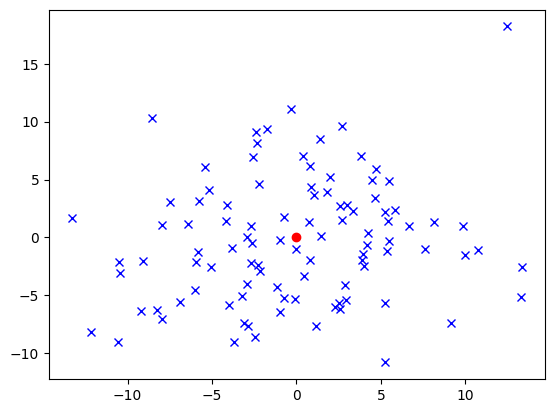

In [58]:
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt, patches
import pprint

N = 100
MAX_RANGE = 50
TIME_LIMIT = 40
RUN_OPT = True

G = nx.DiGraph()
rng = np.random.default_rng(seed=42)
for i in range(N):
    if i == 0:
        rng.normal(0, MAX_RANGE / 2 / 4, size=(2,))
        pos = np.array([0.0, 0.0])
    else:
        pos = rng.normal(0, MAX_RANGE / 2 / 4, size=(2,))
    G.add_node(i, pos=pos)
for node, pos in G.nodes.data("pos"):
    for other_node, other_pos in G.nodes.data("pos"):
        if node == other_node:
            continue
        dist = np.linalg.norm(pos - other_pos) + rng.normal(0, 1)
        G.add_edge(node, other_node, weight=dist)
# pprint.pprint(list(G.nodes))
# pprint.pprint(list(data["pos"] for _, data in G.nodes.data()))
# pprint.pprint(list(G.edges))
# pprint.pprint(list(data["weight"] for _, _, data in G.edges.data()))

def plot_G(G):
    for node, pos in G.nodes.data("pos"):
        if node == 0:
            plt.plot(pos[0], pos[1], "or")
            continue
        plt.plot(pos[0], pos[1], "xb")
        

def extract_subtours(selected):
    H = nx.DiGraph(selected)
    cycles = list(nx.simple_cycles(H))
    for cycle in cycles:
        cycle.append(cycle[0])
    return cycles


def plot_tours(G, tours):
    plot_G(G)
    for tour, color in zip(tours, plt.rcParams["axes.prop_cycle"].by_key()["color"]):
        for i, j in zip(tour, tour[1:]):
            pos_i = G.nodes[i]["pos"]
            pos_j = G.nodes[j]["pos"]
            delta = pos_j - pos_i
            plt.arrow(pos_i[0], pos_i[1], delta[0], delta[1], color=color)

plot_G(G)

[(0, 1, 7.8579608602677515), (0, 2, 16.067975350750437), (0, 3, 2.2224904685978424), (0, 4, 5.976497327236992), (0, 5, 5.287394692242357), (0, 6, 7.008615969208979), (0, 7, 5.270753834625189), (0, 8, 5.202078691962567), (0, 9, 4.621022032947978), (0, 10, 4.075733849975257), (0, 11, 8.617583278147912), (0, 12, 2.139190074036978), (0, 13, 4.066130383315123), (0, 14, 3.244703057256128), (0, 15, 13.296506370404655), (0, 16, 7.012576181046297), (0, 17, 8.576133224485575), (0, 18, 6.636450679336258), (0, 19, 6.4096020125048545), (0, 20, 5.057600190205901), (0, 21, 4.181402820601528), (0, 22, 1.7916936647820592), (0, 23, 5.799430882616688), (0, 24, 3.179791200883524), (0, 25, 4.430145454448218), (0, 26, 9.552031809646417), (0, 27, 7.475955324692052), (0, 28, 11.377158714734758), (0, 29, 7.265086827368856), (0, 30, 10.436783730829877), (0, 31, 2.3390303743024954), (0, 32, 6.068529649907066), (0, 33, 3.93509627155329), (0, 34, 6.699884321685663), (0, 35, 9.935759663831723), (0, 36, 5.8787071658

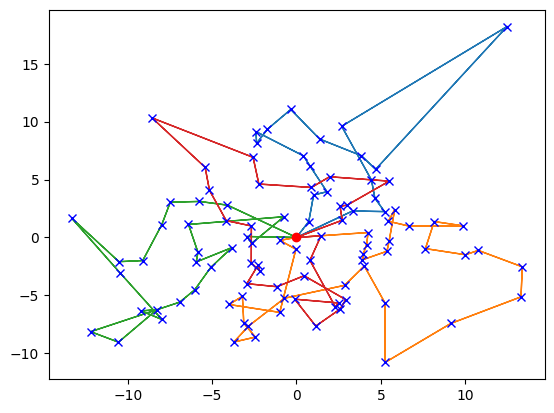

In [59]:
import gurobipy as gp

print(G.edges.data("weight"))
model = gp.Model()
x = model.addVars(
    G.edges,
    obj={(i, j): weight for i, j, weight in G.edges.data("weight")},
    vtype=gp.GRB.BINARY,
    name="x",
)
z = model.addVars(G.nodes)
model.addConstr(x.sum(0, "*") == x.sum("*", 0))
model.addConstr(z[0] == 0)
model.addConstrs(x.sum(i, "*") == 1 for i in list(G.nodes)[1:])
model.addConstrs(x.sum("*", i) == 1 for i in list(G.nodes)[1:])
model.addConstrs(
    z[j] >= z[i] + G.edges[i,j]["weight"] - MAX_RANGE * (1 - x[i, j])
    for i in G.nodes
    for j in list(G.nodes)[1:]
    if i != j
)
model.addConstrs(
    z[j] <= z[i] + G.edges[i,j]["weight"] + MAX_RANGE * (1 - x[i, j])
    for i in G.nodes
    for j in list(G.nodes)[1:]
    if i != j
)
# for i, j, weight in G.edges.data("weight"):
#     if j == 0:
#         continue
#     model.addGenConstrIndicator(x[i, j], True, d[j] == d[i] + weight)
model.addConstrs(z[i] >= 0 for i in list(G.nodes)[1:])
model.addConstrs(
    z[i] <= MAX_RANGE - G.edges[i, 0]["weight"] for i in list(G.nodes)[1:]
)

model.Params.TimeLimit = TIME_LIMIT
if RUN_OPT:
    model.optimize()

    vals = model.getAttr("x", x)
    # print(vals)
    selected = gp.tuplelist((i, j) for i, j in vals.keys() if vals[i, j] > 0.5)
    print(list(selected))
    tours = extract_subtours(selected)
    print(tours)
    plot_tours(G, tours)

[(0, 1, 7.8579608602677515), (0, 2, 16.067975350750437), (0, 3, 2.2224904685978424), (0, 4, 5.976497327236992), (0, 5, 5.287394692242357), (0, 6, 7.008615969208979), (0, 7, 5.270753834625189), (0, 8, 5.202078691962567), (0, 9, 4.621022032947978), (0, 10, 4.075733849975257), (0, 11, 8.617583278147912), (0, 12, 2.139190074036978), (0, 13, 4.066130383315123), (0, 14, 3.244703057256128), (0, 15, 13.296506370404655), (0, 16, 7.012576181046297), (0, 17, 8.576133224485575), (0, 18, 6.636450679336258), (0, 19, 6.4096020125048545), (0, 20, 5.057600190205901), (0, 21, 4.181402820601528), (0, 22, 1.7916936647820592), (0, 23, 5.799430882616688), (0, 24, 3.179791200883524), (0, 25, 4.430145454448218), (0, 26, 9.552031809646417), (0, 27, 7.475955324692052), (0, 28, 11.377158714734758), (0, 29, 7.265086827368856), (0, 30, 10.436783730829877), (0, 31, 2.3390303743024954), (0, 32, 6.068529649907066), (0, 33, 3.93509627155329), (0, 34, 6.699884321685663), (0, 35, 9.935759663831723), (0, 36, 5.8787071658

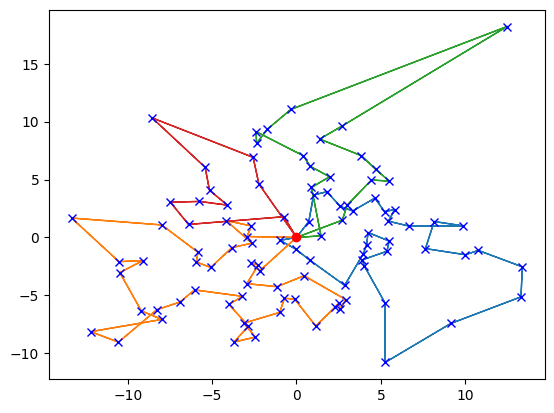

In [60]:
import gurobipy as gp

print(G.edges.data("weight"))
model = gp.Model()
x = model.addVars(
    G.edges,
    obj={(i, j): weight for i, j, weight in G.edges.data("weight")},
    vtype=gp.GRB.BINARY,
    name="x",
)
z = model.addVars(G.edges)

model.addConstr(x.sum(0, "*") == x.sum("*", 0))
model.addConstrs(x.sum(i, "*") == 1 for i in list(G.nodes)[1:])
model.addConstrs(x.sum("*", i) == 1 for i in list(G.nodes)[1:])

model.addConstrs(
    z.sum(i, "*")
    == z.sum("*", i)
    + gp.quicksum(G.edges[i, j]["weight"] * x[i, j] for j in G.nodes if i != j)
    for i in list(G.nodes)[1:]
)
model.addConstrs(
    z[i, j] <= (MAX_RANGE - G.edges[j, 0]["weight"]) * x[i, j]
    for i in G.nodes
    for j in list(G.nodes)[1:]
    if i != j
)
model.addConstrs(
    z[i, 0] <= MAX_RANGE * x[i, 0] for i in list(G.nodes)[1:]
)
# model.addConstrs(
#     z[i, j] >= (G.edges[i, j]["weight"] + G.edges[0, i]["weight"]) * x[i, j]
#     for i in list(G.nodes)[1:]
#     for j in G.nodes
#     if i != j
# )
model.addConstrs(z[0, i] == G.edges[0, i]["weight"] * x[0, i] for i in list(G.nodes)[1:])

model.Params.TimeLimit = TIME_LIMIT
if RUN_OPT:
    model.optimize()

    vals = model.getAttr("x", x)
    # print(vals)
    selected = gp.tuplelist((i, j) for i, j in vals.keys() if vals[i, j] > 0.5)
    print(list(selected))
    tours = extract_subtours(selected)
    print(tours)
    plot_tours(G, tours)

In [61]:
import itertools


def greedy_edge_heuristic(G: nx.DiGraph):
    H = nx.DiGraph()
    for i, j, weight in G.edges.data("weight"):
        if i == 0 or j == 0:
            continue
        node_i = (0, i, 0)
        node_j = (0, j, 0)
        H.add_edge(node_i, node_j, weight=weight)
        H.nodes[node_i]["length"] = node_length(node_i)
        H.nodes[node_j]["length"] = node_length(node_j)
    # print(list(H.nodes.data("length")))
    keep_going = True
    count = 1
    while keep_going:
        i, j, weight = min(H.edges.data("weight"), key=lambda i, j, weight: weight)
        new_node = node_concatentate(i, j)
        new_length = node_length(G, node)
        count += 1
        keep_going = count < len(G.nodes) - 2
        if new_length > MAX_RANGE:
            H.remove_edge(i, j)
            continue
        H.remove_node(i)
        H.remove_node(j)
        H.add_node(new_node, length=new_length)
        H.add_edges_from(
            (i, new_node, {"weight": G.edges[last(i), first(new_node)]["weight"]})
            for i in H.nodes
            if i != new_node
        )
        H.add_edges_from(
            (new_node, j, {"weight": G.edges[last(new_node), first(j)]["weight"]})
            for j in H.nodes
            if j != new_node
        )


# greedy_edge_heuristic(G)

In [62]:
import time

import numpy as np
import numpy.typing as npt
import pygad
import verypy
import verypy.util
from verypy.local_search import (
    do_local_search,
    inter_route_operators,
    intra_route_operators,
)

rng = np.random.default_rng(42)

distance_matrix = np.inf * np.ones((len(G.nodes), len(G.nodes)))
for i, j, dist in G.edges.data("weight"):
    distance_matrix[i, j] = dist


def improve_solution(sol):
    ls_ops = [
        inter_route_operators.do_1point_move,
        inter_route_operators.do_2optstar_move,
        intra_route_operators.do_2opt_move,
        intra_route_operators.do_relocate_move,
    ]
    new_solution = do_local_search(
        ls_ops, sol, distance_matrix, None, None, L=MAX_RANGE, max_iterations=10
    )
    if new_solution == sol:
        return False, None
    print("Improved the solution!")
    return True, new_solution


def routes2sol(routes: list[list[int]]) -> list[int]:
    sol = []
    for route in routes:
        sol.extend(route[:-1])
    sol.append(0)
    return sol


def sol2routes(sol: list[int]) -> list[list[int]]:
    routes = []
    route = [sol[0]]
    for node in sol[1:]:
        if node == 0:
            route.append(node)
            routes.append(route)
            route = [node]
            continue
        route.append(node)
    return routes


def sol2edgeset(sol: list[int]) -> set[tuple[int, int]]:
    edgeset = set()
    for i, j in zip(sol, sol[1:]):
        edgeset.add((i, j))
    return edgeset


def distance(edgeset: set[tuple[int, int]]) -> float:
    """Calculate the distance of the edges."""
    return sum(G.edges[i, j]["weight"] for i, j in edgeset if i != j)


def fitness(ga: pygad.GA, sol: npt.NDArray, sol_idx: int) -> float:
    """Fitness of a route solution."""
    new_sol = sol.copy()
    new_sol[sol >= N] = 0
    edgeset = sol2edgeset(new_sol.tolist())
    return -distance(edgeset)


def random_population(population_size: int) -> npt.NDArray:
    """Generate a random population."""
    pop = np.zeros((population_size, 2 * N + 1), dtype=np.int16)
    for i in range(population_size):
        pop[i] = random_individual()
    return pop


def random_individual() -> npt.NDArray:
    """Generate a random individual."""
    nodes = np.array(list(G.nodes)[1:], dtype=np.int16)
    rng.shuffle(nodes)
    individual = np.arange((2 * N + 1), dtype=np.int16)
    i = 1
    prev_node = 0
    running_dist = 0
    depot_count = 0
    for node in nodes:
        dist = G.edges[prev_node, node]["weight"]
        return_dist = G.edges[node, 0]["weight"]
        if running_dist + dist + return_dist > MAX_RANGE:
            individual[i] = N + depot_count
            depot_count += 1
            i += 1
            running_dist = 0
            prev_node = 0
            dist = G.edges[prev_node, node]["weight"]
        running_dist += dist
        individual[i] = node
        prev_node = node
        i += 1
    return individual


def route_distance(route):
    """Calculate the distance of the route."""
    edgeset = sol2edgeset(route)
    return distance(edgeset)


def check_distance_constraints(population: npt.NDArray) -> npt.NDArray[np.bool_]:
    """Determine which individuals respect the distance constraint."""
    valid = np.zeros((population.shape[0],), dtype=np.bool_)
    for i, individual in enumerate(population):
        individual_ = individual.copy()
        individual_[individual >= N] = 0
        routes = sol2routes(individual_)
        valid[i] = all(route_distance(route) <= MAX_RANGE for route in routes)
    return valid


def mutation(offspring: npt.NDArray, ga: pygad.GA) -> npt.NDArray:
    """Perform the mutation operations."""
    if ga.mutation_probability is None:
        raise RuntimeError(
            "The `mutation_probability` field must be set on the pygad.GA instance."
        )
    prob: float = ga.mutation_probability
    rand = rng.uniform(size=(offspring.shape[0],))
    row_where = rand <= prob
    col_where = rng.choice(
        np.arange(1, offspring.shape[1] - 1, dtype=np.int16),
        size=(row_where.sum(), 2),
        replace=True,
    )
    new_offspring = offspring.copy()
    new_offspring[row_where, col_where.T] = offspring[row_where, col_where[..., ::-1].T]
    valid = check_distance_constraints(new_offspring)
    new_offspring[~valid] = offspring[~valid]
    np.place(new_offspring, new_offspring >= N, np.arange(N, 2*N+1))
    return new_offspring


def find_next_unvisited_after(
    solution: npt.NDArray, visited: set[int], after_node: int, depot_count: int
) -> int | None:
    """Find the next node that has not been visited after the given node."""
    end_idx = np.argwhere(solution < N)[-1][0]
    if after_node < N:
        after_idx = np.argwhere(solution == after_node)[0][0]
    else:
        after_idx = np.argwhere(solution >= N)[depot_count - 1][0]
    for i in itertools.chain(range(after_idx + 1, end_idx + 1), range(1, after_idx)):
        node = solution[i]
        if node in visited or N <= node < N + depot_count:
            continue
        return node
    return None


def sequential_constructive_crossover(
    parent1: npt.NDArray, parent2: npt.NDArray
) -> npt.NDArray:
    """Perform the sequential constructive crossover routine."""
    offspring = np.arange((2 * N + 1), dtype=np.int16)
    visited = set()
    i = 1
    route_dist = 0
    prev_node = 0
    depot_count = 0
    while len(visited) < N - 1:
        node1 = find_next_unvisited_after(parent1, visited, prev_node, depot_count)
        node2 = find_next_unvisited_after(parent2, visited, prev_node, depot_count)
        dist1 = float("inf")
        return_dist1 = 0.0
        dist2 = float("inf")
        return_dist2 = 0.0
        prev_node_ = 0 if prev_node >= N else prev_node
        if node1 is not None:
            node1_ = 0 if node1 >= N else node1
            if node1_ != prev_node_:
                dist1 = G.edges[prev_node_, node1_]["weight"]
            if node1_ != 0:
                return_dist1 = G.edges[node1_, 0]["weight"]
        if node2 is not None:
            node2_ = 0 if node2 >= N else node2
            if node2_ != prev_node_:
                dist2 = G.edges[prev_node_, node2_]["weight"]
            if node2_ != 0:
                return_dist2 = G.edges[node2_, 0]["weight"]

        if dist1 < dist2:
            assert node1 is not None
            if route_dist + dist1 + return_dist1 > MAX_RANGE or node1 >= N:
                prev_node = N + depot_count
                depot_count += 1
                route_dist = 0
            else:
                route_dist += dist1
                prev_node = node1
                visited.add(prev_node)
        elif dist2 < dist1 or node2 is not None:
            assert node2 is not None
            if route_dist + dist2 + return_dist2 > MAX_RANGE or node2 >= N:
                prev_node = N + depot_count
                depot_count += 1
                route_dist = 0
            else:
                route_dist += dist2
                prev_node = node2
                visited.add(prev_node)
        else:
            raise RuntimeError("Shouldn't have gotten here.")
        offspring[i] = prev_node
        i += 1
    return offspring


def crossover(
    parents: npt.NDArray, offspring_size: tuple[int, ...], ga: pygad.GA
) -> npt.NDArray:
    """Perform the crossover operations."""
    offspring = np.empty(offspring_size, dtype=parents.dtype)
    if ga.crossover_probability is None:
        raise RuntimeError(
            "The `crossover_probability` pygad.GA attribute must be set."
        )
    # prob: float = ga.crossover_probability
    # rand = rng.uniform(size=(parents.shape[0],))
    # row_where = rand <= prob
    # used_parents = parents[row_where]
    used_parents = parents
    parent_pairs = rng.choice(
        np.arange(used_parents.shape[0], dtype=np.int16),
        size=(offspring_size[0], 2),
        replace=True,
    )
    for i, (j, k) in enumerate(parent_pairs):
        offspring[i] = sequential_constructive_crossover(
            used_parents[j], used_parents[k]
        )
    return offspring






No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Init time: 0.22189697799331043
Run time: 133.09331986701
Total time: 133.3152168450033
(array([  0,  43,  46,  84, 100,  99,  57,  33,  41,  27,  64,  75,  18,
         4,  70,   7,  82,  49,  40,   3,   8,  93,  79,  16,  10,  65,
        56,  86,  72,  53,  52,  60, 101,  58,  66,  98,  39,  34,   9,
        74,  62,  83,  23,  20,  44,  14,  55,  13,  68,  78,   6,  31,
        25,  37,  51,  29,  85,  19,  36,  42,  87,  21, 102, 103,  89,
       104,  22, 105, 106,  12,  38, 107,  90,  11,  95,  59,  15,  88,
        81,  63,  54, 108,  80,  97,  48,  67,  35,  76,  26,  30,  47,
         2,  71,  73, 109, 110,  94,  77,  92,  32,   5,   1,  17,  61,
        96,  28,  50,  91, 111, 112, 113, 114, 115, 116, 117, 118,  69,
        24,  45, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 1

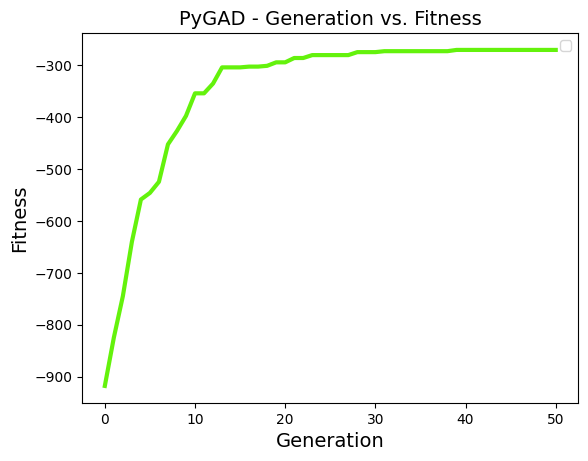

In [63]:
def on_generation(ga: pygad.GA, n_gen_without_improvement: int):
    curr_gen = ga.generations_completed
    last_improvement_gen = ga.best_solution_generation
    if curr_gen - last_improvement_gen >= n_gen_without_improvement:
        print(
            f"{n_gen_without_improvement} generations without improvement, randomizing population."
        )
        new_population = random_population(n_pop)
        ga.population = new_population
        # ga.


start_time = time.perf_counter()
n_pop = 200
initial_population = random_population(n_pop)
# print(initial_population)
ga = pygad.GA(
    num_generations=50,
    num_parents_mating=n_pop // 2,
    fitness_func=fitness,
    initial_population=initial_population,
    parent_selection_type="rws",
    random_seed=42,
    gene_type=int,
    # gene_space=range(N),
    crossover_probability=0.5,
    mutation_probability=0.25,
    crossover_type=crossover,
    mutation_type=mutation,
)
init_time = time.perf_counter()
ga.run()
run_time = time.perf_counter()
print(f"Init time: {init_time - start_time}")
print(f"Run time: {run_time - init_time}")
print(f"Total time: {run_time - start_time}")
print(ga.best_solution())
a = ga.plot_fitness()